## DSCI 552: Final Project
### Kayla Hoffman
### USC ID: 5610859816
### Github Username: kaylah176


In [73]:
# Import libraires
import cv2
import math
import os, os.path
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report
from tensorflow.keras import layers, utils
from tensorflow.keras.applications import EfficientNetB0, vgg16, ResNet50, ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras import Model

random.seed(42)
print("Tensorflow version:", tf.__version__)
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")

Tensorflow version: 2.18.0
The number of GPUs: 1


## 1a. Transfer Learning for Image Classification
- In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

## b. Data Exploration and Preprocessing

---



### i.
- Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set your dataset directory
dataset_dir = '/content/drive/MyDrive/RealWaste'

# For reproducibility
random.seed(42)

data = []

# Loop through each class folder
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        # List all jpg files in the class folder
        images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
        # Full paths
        image_paths = [os.path.join(class_path, img) for img in images]
        # Shuffle images
        random.shuffle(image_paths)
        # Split index
        split_idx = int(0.8 * len(image_paths))
        # Assign to train and test
        for img_path in image_paths[:split_idx]:
            data.append({'filepath': img_path, 'label': class_folder, 'set': 'train'})
        for img_path in image_paths[split_idx:]:
            data.append({'filepath': img_path, 'label': class_folder, 'set': 'test'})

# Create DataFrame
df = pd.DataFrame(data)

# Example: Save as CSV (optional)
df.to_csv('image_dataset_split.csv', index=False)

# Display first few rows
print(df.head())


                                            filepath            label    set
0  /content/drive/MyDrive/RealWaste/2-Food Organi...  2-Food Organics  train
1  /content/drive/MyDrive/RealWaste/2-Food Organi...  2-Food Organics  train
2  /content/drive/MyDrive/RealWaste/2-Food Organi...  2-Food Organics  train
3  /content/drive/MyDrive/RealWaste/2-Food Organi...  2-Food Organics  train
4  /content/drive/MyDrive/RealWaste/2-Food Organi...  2-Food Organics  train


In [ ]:
# Split into X_train and X_test DataFrames
X_train = df[df['set'] == 'train'].reset_index(drop=True)
X_test = df[df['set'] == 'test'].reset_index(drop=True)

# Show results
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
# print(X_train.head())
# print(X_test.head())


Training set size: 3806
Test set size: 956


In [ ]:
X_train.head()

,filepath,label,set
0,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train
1,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train
2,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train
3,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train
4,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train


### Encode classes using "One-hot" encoding

In [ ]:
encoder = OneHotEncoder()

# Fit on all labels to ensure same columns for train/test
all_labels = pd.concat([X_train['label'], X_test['label']]).values.reshape(-1, 1)
encoder.fit(all_labels)

# Transform train and test labels
y_train = encoder.transform(X_train['label'].values.reshape(-1, 1))
y_test = encoder.transform(X_test['label'].values.reshape(-1, 1))

# If you want to see the class order
print(encoder.categories_)


[array(['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal',
       '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash',
       '9-Vegetation'], dtype=object)]


### ii.
- In case all images do not have the same size, zero-pad, or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [ ]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or cannot be read: {img_path}")

    h, w = img.shape[:2]
    target_h, target_w = target_size

    # Resize if larger than target size, preserving aspect ratio
    if h > target_h or w > target_w:
        scale = min(target_h / h, target_w / w)
        new_w = int(w * scale)
        new_h = int(h * scale)
        img = cv2.resize(img, (new_w, new_h))
        h, w = img.shape[:2]

    # Calculate padding
    delta_w = target_w - w
    delta_h = target_h - h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_img


In [ ]:
X_train['image'] = X_train['filepath'].apply(lambda x: load_and_preprocess_image(x, target_size=(224, 224)))
X_test['image'] = X_test['filepath'].apply(lambda x: load_and_preprocess_image(x, target_size=(224, 224)))

In [ ]:
X_train.columns

Index(['filepath', 'label', 'set', 'image'], dtype='object')

## c) Transfer Learning

---



## i.
- Transfer Learning: The reuse of a pretrained model on a new problem. The idea is that such deep networks have learning to extract meaningful features from an image using their layers. In order to do that, the last layer of the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one or more multiple replacement layers.

- In this project use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16.

- Only train the last fully connected layer, and will freeze all layers before them and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.


## ii.
Perform empirical regularization by cropping, randomly zooming, rotating, flipping, contrasting, and translate images in your training set for image augmentation. You can use OpenCV

In [ ]:
def augment_image(image):
    # Random flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
    # Random rotation
    angle = np.random.uniform(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    # Random zoom
    scale = np.random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    # Random crop
    h, w = image.shape[:2]
    crop_h, crop_w = int(h*0.8), int(w*0.8)
    start_x = np.random.randint(0, w - crop_w + 1)
    start_y = np.random.randint(0, h - crop_h + 1)
    image = image[start_y:start_y+crop_h, start_x:start_x+crop_w]
    return image

X_train['augmented_image'] = X_train['image'].apply(augment_image)

print(X_train.shape)
print(X_test.shape)

(3806, 5)
(956, 4)


In [54]:
X_train.head()

,filepath,label,set,image,augmented_image
0,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train,"[[[181, 183, 183], [151, 153, 153], [174, 179,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train,"[[[225, 194, 171], [226, 193, 171], [227, 194,...","[[[216, 185, 163], [211, 182, 158], [185, 160,..."
2,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train,"[[[193, 190, 185], [221, 216, 217], [157, 154,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train,"[[[181, 188, 191], [163, 170, 173], [164, 170,...","[[[218, 220, 221], [215, 218, 219], [210, 214,..."
4,/content/drive/MyDrive/RealWaste/2-Food Organi...,2-Food Organics,train,"[[[187, 159, 142], [194, 164, 145], [212, 181,...","[[[0, 0, 0], [1, 1, 1], [193, 165, 144], [183,..."


## iii.
- Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer.

- Try any batch size, but a batch size of 5 seems reasonable.

- Use multinomial cross entropy loss.

## Construct EfficientNetB0

In [ ]:
# Define the model
EfficientNet_base = EfficientNetB0(include_top=False, weights='imagenet')

# Freeze the pretrained weights
EfficientNet_base.trainable = False

# Rebuild layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = EfficientNet_base(inputs)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

# First Dense Block
x = layers.BatchNormalization()(x) # batch normalization applied first
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Second Dense block
x = layers.BatchNormalization()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Output Softmax Layer
outputs = layers.Dense(9, activation='softmax', dtype=tf.float32, name='outputLayer')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,236,844 (16.16 MB)

 Trainable params: 184,457 (720.54 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

## Construct VGG16

In [ ]:
# Define the model
VGG_base = vgg16.VGG16(include_top=False, weights='imagenet')

# Freeze the pretrained weights
VGG_base.trainable = False

# Rebuild layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = VGG_base(inputs)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

# First Dense Block
x = layers.BatchNormalization()(x) # batch normalization applied first
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Second Dense block
x = layers.BatchNormalization()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Output Softmax Layer
outputs = layers.Dense(9, activation='softmax', dtype=tf.float32, name='outputLayer')(x)

VGGmodel = Model(inputs=inputs, outputs=outputs)

# Compile the model
VGGmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
VGGmodel.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,800,585 (56.46 MB)

 Trainable params: 84,617 (330.54 KB)

 Non-trainable params: 14,715,968 (56.14 MB)

## Construct ResNet50

In [ ]:
# Define the model
ResNet50_base = ResNet50(include_top=False, weights='imagenet')

# Freeze the pretrained weights
ResNet50_base.trainable = False

# Rebuild layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = ResNet50_base(inputs)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

# First Dense Block
x = layers.BatchNormalization()(x) # batch normalization applied first
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Second Dense block
x = layers.BatchNormalization()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Output Softmax Layer
outputs = layers.Dense(9, activation='softmax', dtype=tf.float32, name='outputLayer')(x)

ResNet50 = Model(inputs=inputs, outputs=outputs)

# Compile the model
ResNet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ResNet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,876,361 (91.08 MB)

 Trainable params: 284,297 (1.08 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

## Construct ResNet101

In [ ]:
# Define the model
ResNet101_base = ResNet101(include_top=False, weights='imagenet')

# Freeze the pretrained weights
ResNet101_base.trainable = False

# Rebuild layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = ResNet101_base(inputs)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

# First Dense Block
x = layers.BatchNormalization()(x) # batch normalization applied first
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Second Dense block
x = layers.BatchNormalization()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

# Output Softmax Layer
outputs = layers.Dense(9, activation='softmax', dtype=tf.float32, name='outputLayer')(x)

ResNet101 = Model(inputs=inputs, outputs=outputs)

# Compile the model
ResNet101.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ResNet101.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,946,825 (163.83 MB)

 Trainable params: 284,297 (1.08 MB)

 Non-trainable params: 42,662,528 (162.74 MB)

### iv.
- Train the networks for at least 50 epochs (preferrably 100 epochs) and perform early stopping using the validation set

- Use a randomly selected subset of 20% of each class as the validation set.

- Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.


#### Stratified Split (20% Validation Set per Class)

In [ ]:
train_df = pd.DataFrame()
val_df = pd.DataFrame()


for label in X_train['label'].unique():
    class_subset = X_train[X_train['label'] == label].sample(frac=1, random_state=42)  # shuffle
    val_count = int(0.2 * len(class_subset))
    val_class = class_subset.iloc[:val_count]
    train_class = class_subset.iloc[val_count:]
    val_df = pd.concat([val_df, val_class], ignore_index=True)
    train_df = pd.concat([train_df, train_class], ignore_index=True)

In [ ]:
train_df.columns

Index(['filepath', 'label', 'set', 'image', 'augmented_image'], dtype='object')

#### Prepare Data for Model

In [ ]:
# Stacking Image Arrays
X_train_images = np.stack(train_df['image'].values)
y_train = train_df['label'].values

X_val_images = np.stack(val_df['image'].values)
y_val = val_df['label'].values

# Create Label Mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
# print(label_mapping)

train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)

# Ensuring labels are integers
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# Restacking and extracting labels (after mapping)
X_train_images = np.stack(train_df['image'].values)
y_train = train_df['label'].values

X_val_images = np.stack(val_df['image'].values)
y_val = val_df['label'].values

### Run EfficientNetB0

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    X_train_images,
    y_train,
    batch_size=5,
    epochs=100,
    validation_data=(X_val_images, y_val),
    callbacks=[early_stop]
)


Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.4112 - loss: 4.8747 - val_accuracy: 0.7678 - val_loss: 2.9443
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.6208 - loss: 3.0717 - val_accuracy: 0.7639 - val_loss: 2.1886
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6636 - loss: 2.3945 - val_accuracy: 0.7612 - val_loss: 1.8436
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6757 - loss: 2.0934 - val_accuracy: 0.7691 - val_loss: 1.6909
Epoch 5/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6647 - loss: 2.0082 - val_accuracy: 0.7757 - val_loss: 1.7060
Epoch 6/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6841 - loss: 1.9937 - val_accuracy: 0.7639 - val_loss: 1.7016
Epoch 7/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6908 - loss: 1.9172 - val_accuracy: 0.7942 - val_loss: 1.6663
Epoch 8/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6871 - loss: 1.

# v.
- Report training, validation, and test Precision, Recall, AUC, and F1 score for those models.
- Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem

## Plot the Training and Validation Error Rates

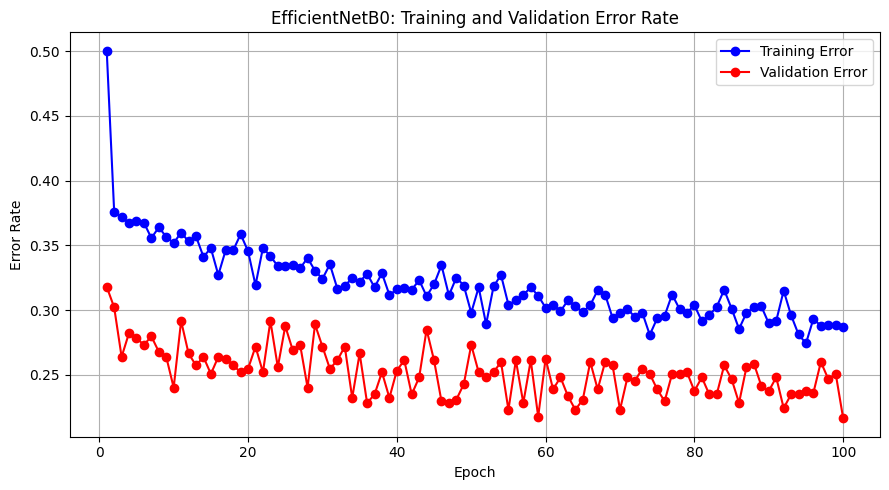

In [61]:
# Number of epochs you intended to train
max_epochs = 100

# Retrieve metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Pad with last value if early stopping occurred
def pad_to_length(lst, length):
    return lst + [lst[-1]] * (length - len(lst))

train_acc = pad_to_length(train_acc, max_epochs)
val_acc = pad_to_length(val_acc, max_epochs)
train_loss = pad_to_length(train_loss, max_epochs)
val_loss = pad_to_length(val_loss, max_epochs)

# Calculate error rates (1 - accuracy)
train_error = [1 - acc for acc in train_acc]
val_error = [1 - acc for acc in val_acc]
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(9, 5))

# Plot error rates
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('EfficientNetB0: Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


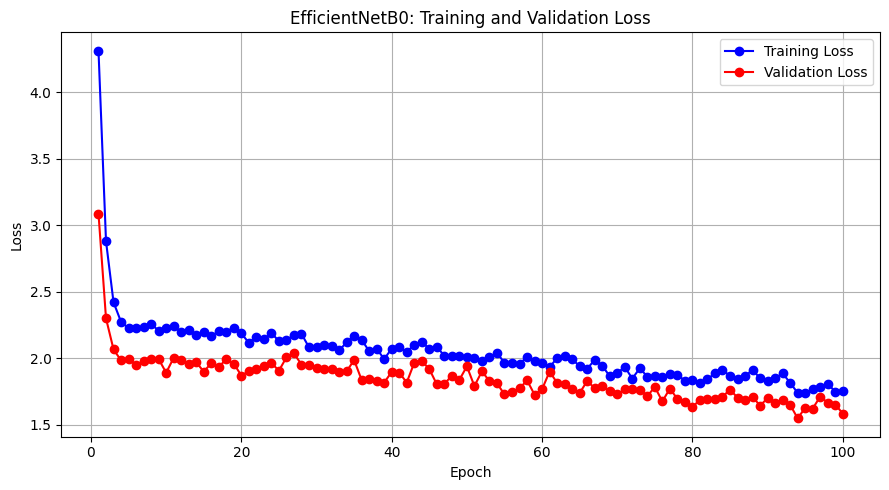

In [62]:
# Plot loss
plt.figure(figsize=(9,5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('EfficientNetB0: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Print the Classification Report

In [63]:
# Predict probabilities for each class
y_val_pred_probs = model.predict(X_val_images)
# Convert probabilities to class indices
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


# Optionally define class names for readability
class_names = [
    "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash",
    "Paper", "Plastic", "Textile Trash", "Vegetation"
]

print(classification_report(y_val, y_val_pred, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
                     precision    recall  f1-score   support

          Cardboard       0.85      0.77      0.81        73
      Food Organics       0.76      0.90      0.82        67
              Glass       0.85      0.90      0.87        67
              Metal       0.83      0.81      0.82       126
Miscellaneous Trash       0.70      0.62      0.66        79
              Paper       0.85      0.89      0.87        80
            Plastic       0.81      0.80      0.80       147
      Textile Trash       0.76      0.76      0.76        50
         Vegetation       0.86      0.88      0.87        69

           accuracy                           0.81       758
          macro avg       0.81      0.81      0.81       758
       weighted avg       0.81      0.81      0.81       758



### VGG16

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True
)

history = VGGmodel.fit(
    X_train_images,
    y_train,
    batch_size=5,
    epochs=100,
    validation_data=(X_val_images, y_val),
    callbacks=[early_stop]
)


Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.3371 - loss: 4.8312 - val_accuracy: 0.6412 - val_loss: 3.0794
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.5810 - loss: 3.0680 - val_accuracy: 0.7018 - val_loss: 2.2405
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6193 - loss: 2.3461 - val_accuracy: 0.7177 - val_loss: 1.7838
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6066 - loss: 2.0525 - val_accuracy: 0.7335 - val_loss: 1.6158
Epoch 5/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6380 - loss: 1.8367 - val_accuracy: 0.7322 - val_loss: 1.5752
Epoch 6/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6282 - loss: 1.8099 - val_accuracy: 0.7309 - val_loss: 1.5486
Epoch 7/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6528 - loss: 1.7350 - val_accuracy: 0.7309 - val_loss: 1.5021
Epoch 8/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6443 - loss: 1

## VGG16 Plots

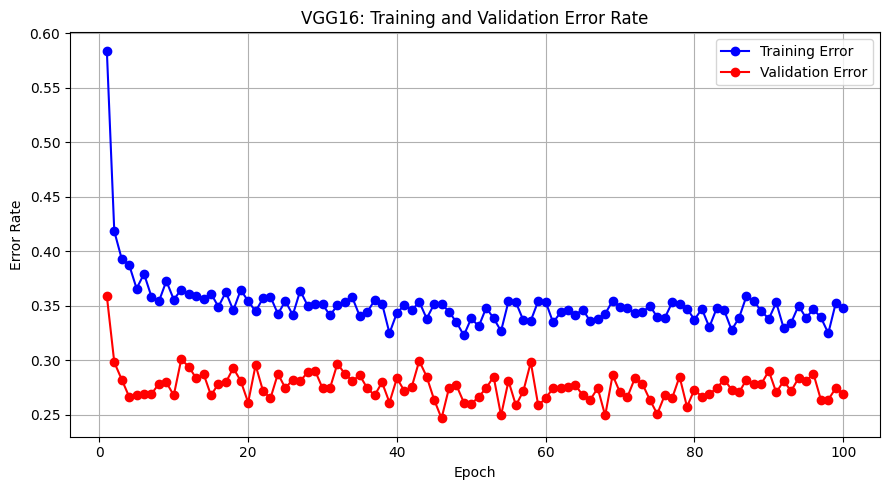

In [ ]:
# Number of epochs you intended to train
max_epochs = 100

# Retrieve metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Pad with last value if early stopping occurred
def pad_to_length(lst, length):
    return lst + [lst[-1]] * (length - len(lst))

train_acc = pad_to_length(train_acc, max_epochs)
val_acc = pad_to_length(val_acc, max_epochs)
train_loss = pad_to_length(train_loss, max_epochs)
val_loss = pad_to_length(val_loss, max_epochs)

# Calculate error rates (1 - accuracy)
train_error = [1 - acc for acc in train_acc]
val_error = [1 - acc for acc in val_acc]
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(9, 5))

# Plot error rates
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('VGG16: Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


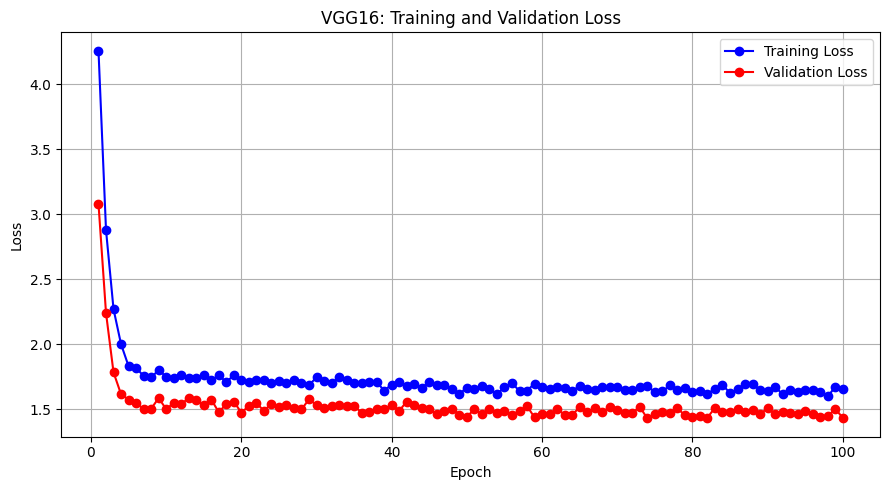

In [ ]:
# Plot loss
plt.figure(figsize=(9,5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('VGG16: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Predict probabilities for each class
y_val_pred_probs = VGGmodel.predict(X_val_images)
# Convert probabilities to class indices
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


# Optionally define class names for readability
class_names = [
    "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash",
    "Paper", "Plastic", "Textile Trash", "Vegetation"
]

print(classification_report(y_val, y_val_pred, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 550ms/step
                     precision    recall  f1-score   support

          Cardboard       0.69      0.67      0.68        73
      Food Organics       0.71      0.76      0.73        67
              Glass       0.77      0.84      0.80        67
              Metal       0.68      0.83      0.75       126
Miscellaneous Trash       0.71      0.46      0.55        79
              Paper       0.79      0.82      0.80        80
            Plastic       0.73      0.65      0.69       147
      Textile Trash       0.81      0.70      0.75        50
         Vegetation       0.81      0.94      0.87        69

           accuracy                           0.74       758
          macro avg       0.74      0.74      0.74       758
       weighted avg       0.74      0.74      0.73       758



## ResNet50

In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True
)

history = ResNet50.fit(
    X_train_images,
    y_train,
    batch_size=5,
    epochs=100,
    validation_data=(X_val_images, y_val),
    callbacks=[early_stop]
)

Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4209 - loss: 4.9470 - val_accuracy: 0.7058 - val_loss: 3.0464
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6422 - loss: 3.0573 - val_accuracy: 0.7269 - val_loss: 2.3201
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6500 - loss: 2.5147 - val_accuracy: 0.7282 - val_loss: 2.1026
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6334 - loss: 2.3307 - val_accuracy: 0.7467 - val_loss: 1.9798
Epoch 5/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6468 - loss: 2.2235 - val_accuracy: 0.7361 - val_loss: 1.9789
Epoch 6/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6662 - loss: 2.1929 - val_accuracy: 0.7309 - val_loss: 1.9683
Epoch 7/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6771 - loss: 2.1514 - val_accuracy: 0.7348 - val_loss: 1.9141
Epoch 8/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6676 - loss: 2

### ResNet 50 Plots

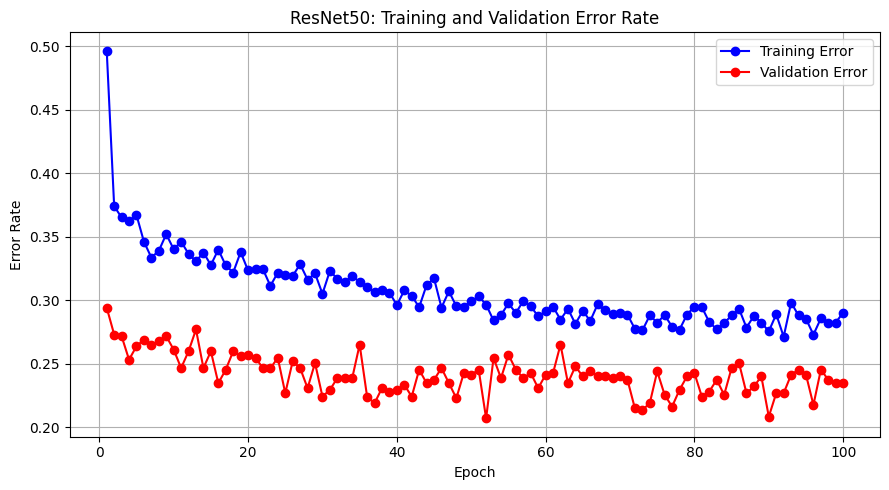

In [37]:
# Number of epochs you intended to train
max_epochs = 100

# Retrieve metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Pad with last value if early stopping occurred
def pad_to_length(lst, length):
    return lst + [lst[-1]] * (length - len(lst))

train_acc = pad_to_length(train_acc, max_epochs)
val_acc = pad_to_length(val_acc, max_epochs)
train_loss = pad_to_length(train_loss, max_epochs)
val_loss = pad_to_length(val_loss, max_epochs)

# Calculate error rates (1 - accuracy)
train_error = [1 - acc for acc in train_acc]
val_error = [1 - acc for acc in val_acc]
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(9, 5))

# Plot error rates
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('ResNet50: Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


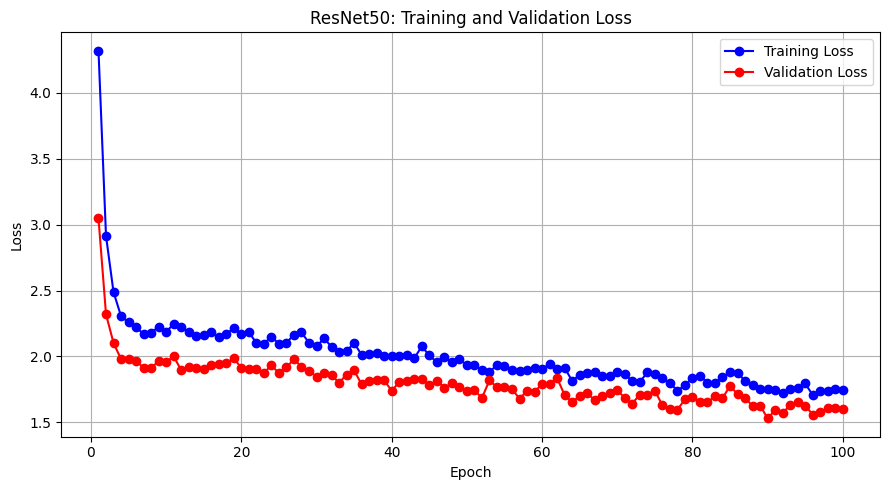

In [38]:
# Plot loss
plt.figure(figsize=(9,5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('ResNet50: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [39]:
# Predict probabilities for each class
y_val_pred_probs = ResNet50.predict(X_val_images)
# Convert probabilities to class indices
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


# Optionally define class names for readability
class_names = [
    "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash",
    "Paper", "Plastic", "Textile Trash", "Vegetation"
]

print(classification_report(y_val, y_val_pred, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step
                     precision    recall  f1-score   support

          Cardboard       0.76      0.78      0.77        73
      Food Organics       0.84      0.88      0.86        67
              Glass       0.91      0.76      0.83        67
              Metal       0.79      0.79      0.79       126
Miscellaneous Trash       0.66      0.62      0.64        79
              Paper       0.89      0.85      0.87        80
            Plastic       0.72      0.80      0.76       147
      Textile Trash       0.73      0.74      0.73        50
         Vegetation       0.94      0.90      0.92        69

           accuracy                           0.79       758
          macro avg       0.80      0.79      0.80       758
       weighted avg       0.80      0.79      0.79       758



## ResNet101

In [40]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True
)

history = ResNet101.fit(
    X_train_images,
    y_train,
    batch_size=5,
    epochs=100,
    validation_data=(X_val_images, y_val),
    callbacks=[early_stop]
)

Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.4034 - loss: 4.9604 - val_accuracy: 0.6821 - val_loss: 3.0886
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6244 - loss: 3.0589 - val_accuracy: 0.6979 - val_loss: 2.3002
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6180 - loss: 2.4861 - val_accuracy: 0.7361 - val_loss: 2.0674
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6391 - loss: 2.2784 - val_accuracy: 0.7177 - val_loss: 1.9844
Epoch 5/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.6618 - loss: 2.1628 - val_accuracy: 0.7216 - val_loss: 1.9934
Epoch 6/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.6287 - loss: 2.2330 - val_accuracy: 0.7269 - val_loss: 1.9519
Epoch 7/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.6554 - loss: 2.1863 - val_accuracy: 0.7203 - val_loss: 1.9801
Epoch 8/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.6406 - loss: 2

### ResNet 101 Plots

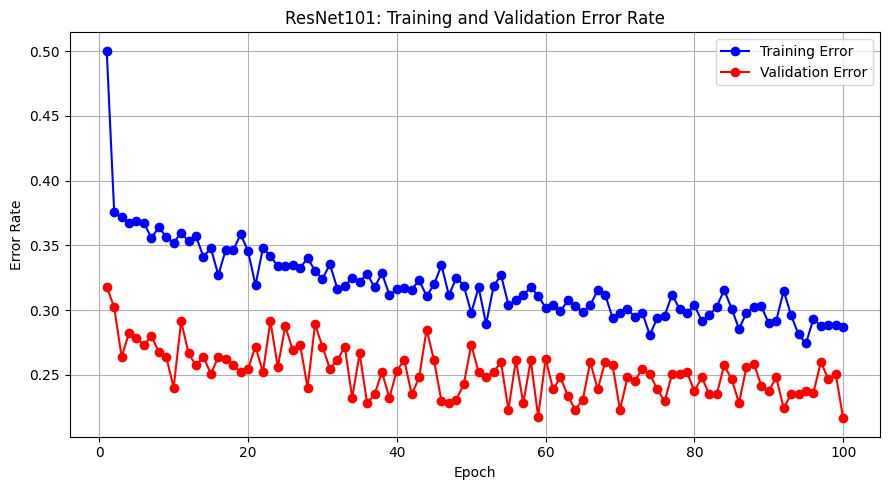

In [48]:
# Number of epochs you intended to train
max_epochs = 100

# Retrieve metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Pad with last value if early stopping occurred
def pad_to_length(lst, length):
    return lst + [lst[-1]] * (length - len(lst))

train_acc = pad_to_length(train_acc, max_epochs)
val_acc = pad_to_length(val_acc, max_epochs)
train_loss = pad_to_length(train_loss, max_epochs)
val_loss = pad_to_length(val_loss, max_epochs)

# Calculate error rates (1 - accuracy)
train_error = [1 - acc for acc in train_acc]
val_error = [1 - acc for acc in val_acc]
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(9, 5))

# Plot error rates
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('ResNet101: Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


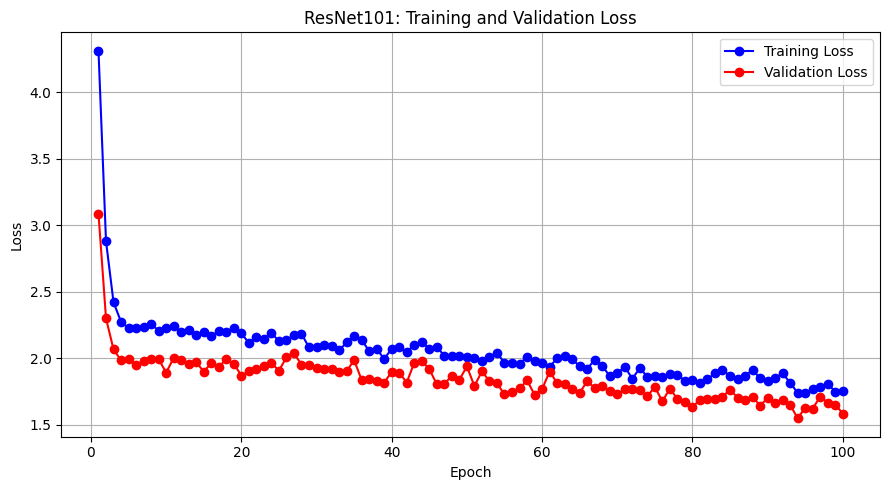

In [57]:
# Plot loss
plt.figure(figsize=(9,5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('ResNet101: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Classification Report

In [59]:
# Predict probabilities for each class
y_val_pred_probs = ResNet101.predict(X_val_images)
# Convert probabilities to class indices
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


# Optionally define class names for readability
class_names = [
    "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash",
    "Paper", "Plastic", "Textile Trash", "Vegetation"
]

print(classification_report(y_val, y_val_pred, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step
                     precision    recall  f1-score   support

          Cardboard       0.68      0.73      0.70        73
      Food Organics       0.85      0.84      0.84        67
              Glass       0.86      0.82      0.84        67
              Metal       0.84      0.78      0.81       126
Miscellaneous Trash       0.60      0.65      0.62        79
              Paper       0.79      0.78      0.78        80
            Plastic       0.72      0.75      0.73       147
      Textile Trash       0.67      0.72      0.69        50
         Vegetation       0.94      0.86      0.89        69

           accuracy                           0.77       758
          macro avg       0.77      0.77      0.77       758
       weighted avg       0.77      0.77      0.77       758



## Plot ROC and AUC Curves

### EfficientNetB0 ROC and AUC Curve

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


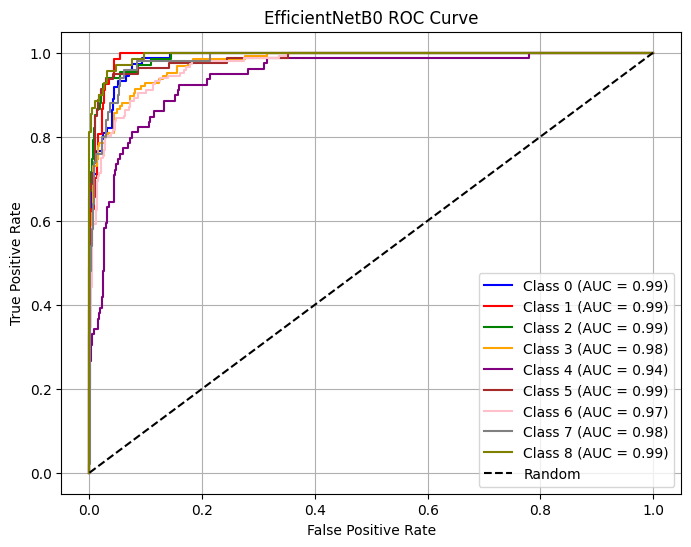

In [68]:
# Number of classes
n_classes = len(np.unique(y_val))

# Binarize the labels
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Get predicted probabilities (should be shape [n_samples, n_classes])
y_pred_prob_model1 = model.predict(X_val_images)  # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob_model1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### VGG16 AUC and ROC Curves

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step


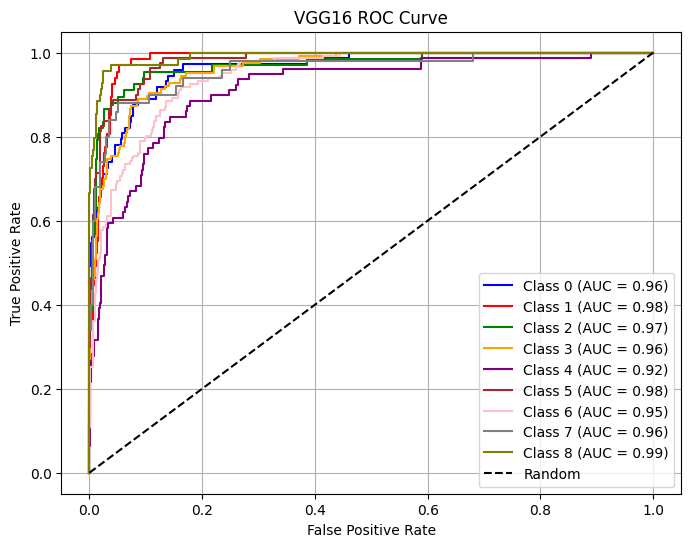

In [70]:
# Number of classes
n_classes = len(np.unique(y_val))

# Binarize the labels
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Get predicted probabilities (should be shape [n_samples, n_classes])
y_pred_prob_model1 = VGGmodel.predict(X_val_images)  # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob_model1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### ResNet50 AUC and ROC Curve

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


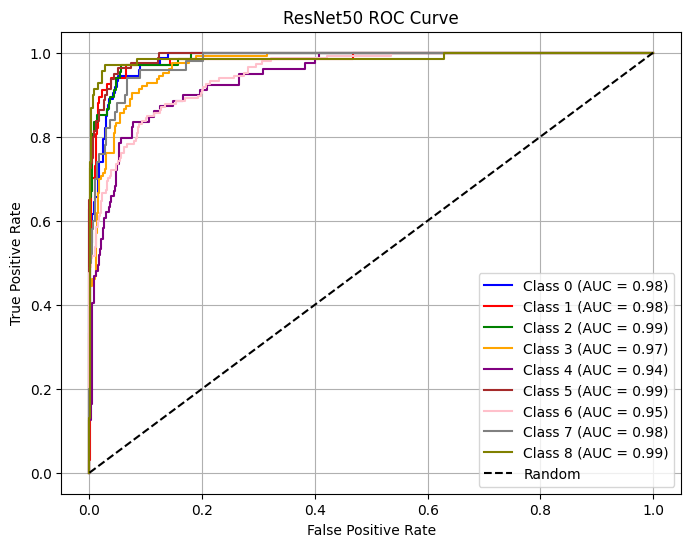

In [71]:
# Number of classes
n_classes = len(np.unique(y_val))

# Binarize the labels
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Get predicted probabilities (should be shape [n_samples, n_classes])
y_pred_prob_model1 = ResNet50.predict(X_val_images)  # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob_model1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### ResNet101 AUC and ROC Curves

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


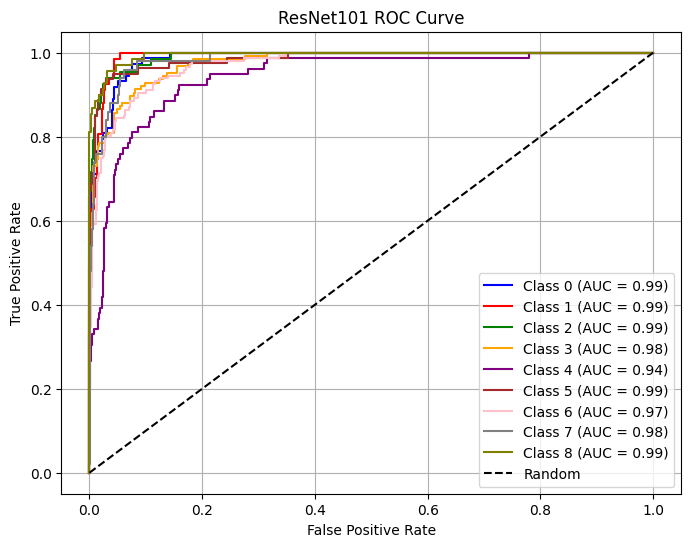

In [72]:
# Number of classes
n_classes = len(np.unique(y_val))

# Binarize the labels
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Get predicted probabilities (should be shape [n_samples, n_classes])
y_pred_prob_model1 = ResNet101.predict(X_val_images)  # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob_model1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet101 ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Overall
The model that outperformed all of the others was EfficientNetB0 with an accuracy scores of 81%, however, this wasn't an exceedingly high outperformance of the other models (VGG16, ResNet50, and ResNet101).

EfficientNetB0 took the least amount of time to run as well thus, its computational cost possible architecture structure it better suit for a multi-classification problem.